## Import package

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import keras
from PIL import Image
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn import metrics
from keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution1D, MaxPooling1D, Flatten,LSTM,Bidirectional,Permute,BatchNormalization,GlobalAveragePooling1D,concatenate,Bidirectional,Masking
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings("ignore")

## Load the data set

In [2]:

def data_sets(folderPath):
    folders = os.listdir(folderPath)
    positive_doc = folders[0]
    negative_doc = folders[1]
    print(folders[1])
    pos_sam = os.listdir(folderPath+'/'+ positive_doc)
    neg_sam = os.listdir(folderPath+'/'+ negative_doc)
    total_pos = len(pos_sam)
    total_neg = len(neg_sam)
    print(total_pos)
    image = np.array(pd.read_excel(folderPath + '/' + folders[0] + '/' + str(pos_sam[0]) , engine='openpyxl',header=None))[:,0]
    print(image.shape[0])
    x_genuine_pair = np.zeros([total_pos, 1, image.shape[0]])  
    y_genuine = np.zeros([total_pos, 1])
    cot = 0
    for count in pos_sam:
        temp1 = np.array(pd.read_excel(folderPath+'/'+str(positive_doc)+'/'+str(count),header=None))[:,0]
        x_genuine_pair[cot,0,:] = temp1
        y_genuine[cot] = 1
        cot+=1
        
    x_false_pair = np.zeros([total_neg, 1, image.shape[0]])
    y_false = np.zeros([total_neg,1])
    cot=0
    for count in neg_sam:
        temp2 = np.array(pd.read_excel(folderPath+'/'+str(negative_doc)+'/'+str(count),header=None))[:,0]
        x_false_pair[cot,0,:] = temp2
        y_false[cot] = 0
        cot+=1
    X = np.concatenate([x_genuine_pair,x_false_pair],axis=0) 
    Y = np.concatenate([y_genuine,y_false],axis=0)
    return X,Y

In [3]:
folderPath ='datajcn'
X,Y=data_sets(folderPath)
print(X.shape,Y.shape)
#Y

normal
75
1000
(150, 1, 1000) (150, 1)


## Normalize to [-1,1]

In [4]:
X_min=np.min(X,2)
X_max=np.max(X,2)


X_max_abs=X_max

for i in range(X.shape[0]):
    for j in range(X.shape[2]):
        if np.absolute(X_min[i,0])>X_max[i,0]:
             X_max_abs[i,0] =  np.absolute(X_min[i,0])
        X[i,0,j]=X[i,0,j]/ X_max_abs[i,0]

In [5]:
X_ne=np.negative(X)
X = np.concatenate([X,X_ne],axis=0) 
Y = np.concatenate([Y,Y],axis=0)

In [6]:
print(X.shape)

(300, 1, 1000)


## Extract feature vectors

In [7]:
chi_x = np.zeros([X.shape[0],200,X.shape[2]])
for sample in range(X.shape[0]):
    for k in range(X.shape[2]):
        value = X[sample,0,k]
        value_100 = int(value*100)
        round  =np.absolute(value_100)
        if value_100 >0:
            for r in range(round):
                chi_x[sample,100+r,k] = 1
        if value_100 <0:
            for r in range(round):
                chi_x[sample,99-r,k]=1
print(chi_x.shape)

(300, 200, 1000)


In [8]:
X_fin = np.sum(chi_x,axis=2)
X_fin.shape

(300, 200)

## Partition the data set

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_fin, Y, test_size=.1,stratify=Y,random_state=7311)
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (270, 200)
y_train (270, 1)
x_test (30, 200)
y_test (30, 1)


(135, 200)


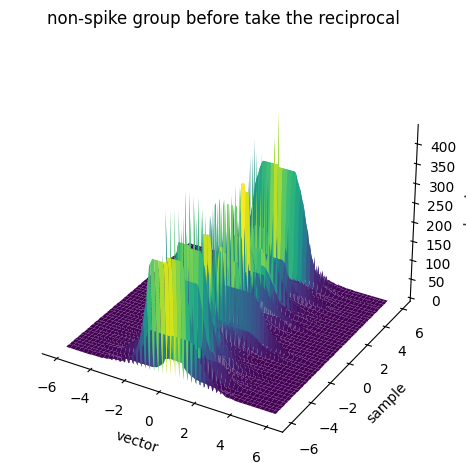

In [10]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 135)
X2, Y2 = np.meshgrid(x, y)
x_huatu=[]
for i in range(270):
    if y_train[i]==1:
        x_huatu.append(x_train[i])
x_huatu=np.array(x_huatu)
print(x_huatu.shape)
Z1 = x_huatu
fig = plt.figure()
ax2 = plt.axes(projection='3d')
ax2.grid(None)
ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
bar=ax2.plot_surface(X2, Y2, Z1,cmap='viridis', edgecolor='none')
ax2.set_xlabel('vector')
ax2.set_ylabel('sample')
ax2.set_zlabel('level')
plt.tight_layout()
ax2.set_title('non-spike group before take the reciprocal')
plt.tight_layout()
plt.show()

(135, 200)


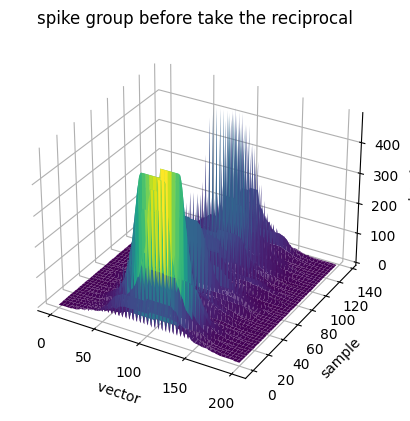

In [11]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x = np.linspace(0, 200, 200)
y = np.linspace(0, 135, 135)

X, Y = np.meshgrid(x, y)
x_huatu=[]
for i in range(270):
    if y_train[i]==0:
        x_huatu.append(x_train[i])
x_huatu=np.array(x_huatu)
print(x_huatu.shape)
Z2 = x_huatu

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.plot_surface(X, Y, Z2,cmap='viridis', edgecolor='none')
ax.set_xlabel(' vector')
ax.set_ylabel('sample')
ax.set_zlabel('level')
ax.set_title('spike group before take the reciprocal')
plt.show()

## Take reciprocal quadratic normalization

In [12]:
def normalization(data):
    num=data.shape[0]
    for i in range(num):
        for j in range(200):
            if data[i,j]!=0:
                data[i,j]=1/data[i,j]
    return data
            

In [13]:
x_train=normalization(x_train)
x_test = normalization(x_test)


(135, 200)


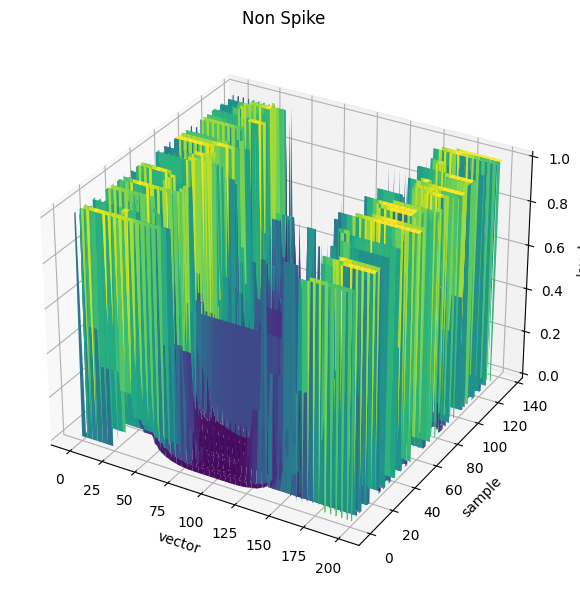

In [14]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
def f(x, y):
   return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(0, 200, 200)
y = np.linspace(0, 135, 135)
X, Y = np.meshgrid(x, y)
x_huatu=[]
for i in range(270):
    if y_train[i]==1:
        x_huatu.append(x_train[i])
x_huatu=np.array(x_huatu)
print(x_huatu.shape)
Z3 = x_huatu
fig = plt.figure(figsize = (12,6))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z3,cmap='viridis', edgecolor='none')
ax.set_xlabel('vector')
ax.set_ylabel('sample')
ax.set_zlabel('level')
ax.set_title('Non Spike')
plt.tight_layout()
plt.show()

(135, 200)


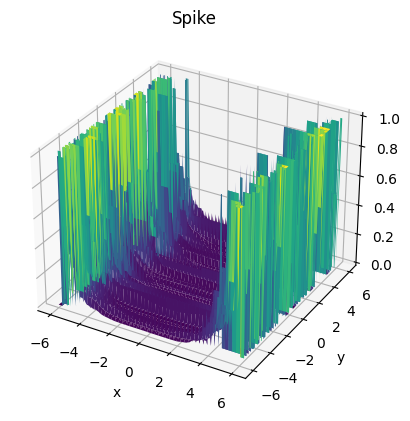

In [15]:
x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 135)

X, Y = np.meshgrid(x, y)
x_huatu=[]
for i in range(270):
    if y_train[i]==0:
        x_huatu.append(x_train[i])
x_huatu=np.array(x_huatu)
print(x_huatu.shape)
Z4 = x_huatu
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z4,cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Spike')
plt.show()

## Deep Neural Network（DNN）

Bayesian optimization takes the best parameters

In [16]:
def create_model(dense_1,dense_2,dense_3,drop_out_1,drop_out_2):
    model = Sequential()
    model.add(Dense(int(dense_1),input_shape=(200,),activation='relu'))
    model.add(Dropout(drop_out_1))
    model.add(Dense(int(dense_2),activation='relu'))
    model.add(Dropout(drop_out_2))
    model.add(Dense(int(dense_3),activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
    return model

In [17]:
def bayeropt_objective(dense_1,dense_2,dense_3,drop_out_1,drop_out_2):
    model_clssification = KerasClassifier(build_fn= create_model,
                                          epochs=20,batch_size=20,dense_1=dense_1,dense_2=dense_2,dense_3=dense_3,drop_out_1=drop_out_1,drop_out_2=drop_out_2,verbose=False)
    cv = KFold(n_splits=5,shuffle=True,random_state=12)
    validation_loss = cross_validate(model_clssification,x_train,y_train,
                                     scoring="f1"
                                    ,cv=cv,
                                     verbose=False
                                    )
    return np.mean(validation_loss['test_score'])

In [18]:
from bayes_opt import BayesianOptimization
def bayesian_opt():
    optimizer = BayesianOptimization(
        f=bayeropt_objective,
        pbounds={'drop_out_1': (0.0, 0.5),'drop_out_2': (0.0, 0.5),  'dense_1': (1, 500), 'dense_2': (1, 200), 'dense_3': (1, 500)},
    )
    optimizer.maximize(
        init_points=5,
        n_iter=5,
    )
    params_best = optimizer.max["params"]
    score_best = optimizer.max["target"]
    print('best:',params_best)
    print('best:',score_best)
    
    return params_best,score_best

In [19]:
params,score=bayesian_opt()

|   iter    |  target   |  dense_1  |  dense_2  |  dense_3  | drop_o... | drop_o... |
-------------------------------------------------------------------------------------
| 1         | 0.8873    | 489.3     | 15.01     | 74.18     | 0.3465    | 0.4232    |
| 2         | 0.8752    | 419.4     | 23.36     | 149.8     | 0.03894   | 0.1787    |
| 3         | 0.8476    | 116.1     | 173.3     | 289.4     | 0.04833   | 0.4918    |
| 4         | 0.8551    | 367.4     | 171.4     | 423.0     | 0.4454    | 0.3096    |
| 5         | 0.8672    | 415.7     | 92.41     | 351.4     | 0.1376    | 0.4063    |
| 6         | 0.8836    | 483.5     | 14.31     | 77.01     | 0.01916   | 0.3332    |
| 7         | 0.8527    | 494.1     | 13.61     | 40.44     | 0.3759    | 0.207     |
| 8         | 0.8474    | 500.0     | 13.65     | 87.35     | 0.5       | 0.5       |
| 9         | 0.8768    | 475.5     | 18.83     | 65.73     | 0.3527    | 0.1178    |
| 10        | 0.8467    | 495.5     | 22.55     | 69.7

In [20]:
model2 = Sequential()
model2.add(Dense(int(params['dense_1']),input_shape=(200,),activation='relu'))
model2.add(Dropout(params['drop_out_1']))
model2.add(Dense(int(params['dense_2']),activation='relu'))
model2.add(Dropout(params['drop_out_2']))
model2.add(Dense(int(params['dense_3']),activation='relu'))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])

In [21]:
hist=model2.fit(x_train, y_train, validation_split=.2, batch_size=20, epochs=20)

Epoch 1/20
11/11 [==============================] - 0s 10ms/step - loss: 0.6211 - accuracy: 0.6250 - val_loss: 0.5106 - val_accuracy: 0.9444
Epoch 2/20
11/11 [==============================] - 0s 3ms/step - loss: 0.5556 - accuracy: 0.7222 - val_loss: 0.4033 - val_accuracy: 0.9259
Epoch 3/20
11/11 [==============================] - 0s 3ms/step - loss: 0.4984 - accuracy: 0.7963 - val_loss: 0.3312 - val_accuracy: 0.9259
Epoch 4/20
11/11 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.8009 - val_loss: 0.3393 - val_accuracy: 0.8704
Epoch 5/20
11/11 [==============================] - 0s 3ms/step - loss: 0.4516 - accuracy: 0.7824 - val_loss: 0.2701 - val_accuracy: 0.9630
Epoch 6/20
11/11 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.8148 - val_loss: 0.2660 - val_accuracy: 0.9259
Epoch 7/20
11/11 [==============================] - 0s 3ms/step - loss: 0.3959 - accuracy: 0.8611 - val_loss: 0.2444 - val_accuracy: 0.9259
Epoch 8/20
11/11 [=

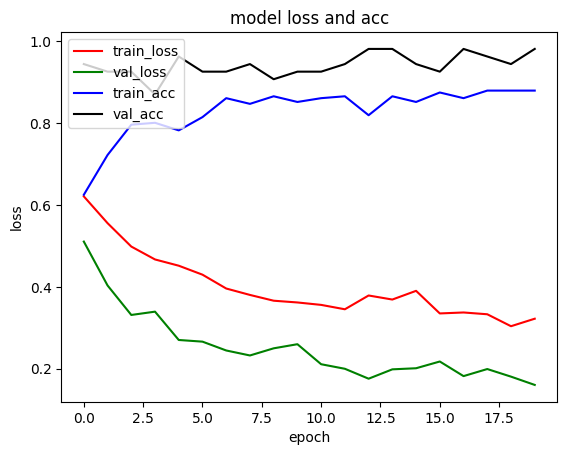

In [22]:
plt.plot(hist.history['loss'],color='r')
plt.plot(hist.history['val_loss'],color='g')
plt.plot(hist.history['accuracy'],color='b')
plt.plot(hist.history['val_accuracy'],color='k')
plt.title('model loss and acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss','train_acc', 'val_acc'], loc='upper left')
plt.show()

In [23]:
pred_y_d=model2.predict(x_test)
pred_y_d=(pred_y_d > 0.5).astype("int32")
DNN_f1=f1_score(y_test,pred_y_d,average='micro')
DNN_acc=accuracy_score(y_test, pred_y_d)
DNN_recall=recall_score(y_test, pred_y_d, average='macro')

In [24]:
print("DNN")
print(metrics.classification_report(np.array(pred_y_d), np.array(y_test)))

DNN
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.87      0.81      0.84        16

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



#### LogisticRegression

In [25]:
from sklearn.linear_model import LogisticRegression
lr_l2_origin = LogisticRegression(penalty="l2", C=0.05 ,solver="sag",max_iter=100000)
p = {
    'C':list(np.linspace(0.001,1,19)),
    'solver':['liblinear','sag','newton-cg','lbfgs'],
    'penalty':['l1','l2']}
# model = LR(penalty='l2',max_iter=10000)
cv = KFold(n_splits=5,shuffle=True,random_state=12)
GS = GridSearchCV(lr_l2_origin,p,cv=cv)
GS.fit(x_train,y_train)
#output best parameter
GS.best_params_
# print(metrics.classification_report(np.array(lr_l1.predict(x_test).ravel()), np.array(y_test.ravel())))

{'C': 0.334, 'penalty': 'l2', 'solver': 'liblinear'}

In [26]:
lr_l2=LogisticRegression(penalty=GS.best_params_['penalty'], C=GS.best_params_['C'],solver=GS.best_params_['solver'],max_iter=100000)
lr_l2.fit(x_train,y_train)
pred_y_r=lr_l2.predict(x_test)
Rl_f1=f1_score(y_test,pred_y_r,average='macro')
Rl_acc=accuracy_score(y_test, pred_y_r)
Rl_recall=recall_score(y_test, pred_y_r, average='macro')

In [27]:
scores = cross_val_score(lr_l2, x_train, y_train, cv=5, scoring='f1_macro')
print("Logistic Regression Score")
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Logistic Regression Score
[0.86996904 0.77747253 0.8703259  0.85164835 0.92592593]
Accuracy: 0.86 (+/- 0.10)


#### SVM

In [28]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
target=[]
C=[]
Gam=[]
from mpl_toolkits.mplot3d import Axes3D
def svc_cv(C, gamma, data, targets):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = svm.SVC(C=C, gamma=gamma, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr', degree=5, kernel='rbf',max_iter=-1, probability=True, shrinking=False,tol=0.00001, verbose=False)
    cv = KFold(n_splits=5,shuffle=True,random_state=12)
    validation_loss = cross_validate(estimator, data, targets, scoring='f1', cv=5)
    return np.mean(validation_loss['test_score'])

def optimize_svc(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""
    def svc_crossval(expC, expGamma):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C =expC
        gamma = 10 ** expGamma
        return svc_cv(C=C, gamma=gamma, data=data, targets=targets)
    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (1, 100), "expGamma": (-5, -1)},
        random_state=1315,
        verbose=2
    )
    optimizer.maximize(init_points=20,n_iter=30)
    print("Final result:", optimizer.max)

    for res in optimizer.res:
        target.append(res['target'])
        C.append(res['params']["expC"])
        Gam.append(res['params']["expGamma"])
    return optimizer.max['params'],optimizer.max
if __name__ == "__main__":
    print("--- Optimizing SVM ---")
    param,p=optimize_svc(x_train,y_train.ravel())


--- Optimizing SVM ---
|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
| 1         | 0.8571    | 19.57     | -1.622    |
| 2         | 0.8404    | 24.67     | -1.473    |
| 3         | 0.8555    | 99.83     | -3.853    |
| 4         | 0.8386    | 71.37     | -1.089    |
| 5         | 0.8737    | 83.59     | -3.647    |
| 6         | 0.8473    | 52.9      | -4.445    |
| 7         | 0.8659    | 50.48     | -2.303    |
| 8         | 0.8354    | 14.59     | -4.119    |
| 9         | 0.8537    | 48.96     | -3.82     |
| 10        | 0.8759    | 87.98     | -3.425    |
| 11        | 0.8537    | 88.81     | -4.114    |
| 12        | 0.8499    | 88.78     | -2.171    |
| 13        | 0.7874    | 55.53     | -4.887    |
| 14        | 0.8736    | 2.141     | -1.343    |
| 15        | 0.8555    | 20.38     | -2.432    |
| 16        | 0.8671    | 12.64     | -2.558    |
| 17        | 0.8537    | 77.43     | -4.376    |
| 18        | 0.8358    | 3

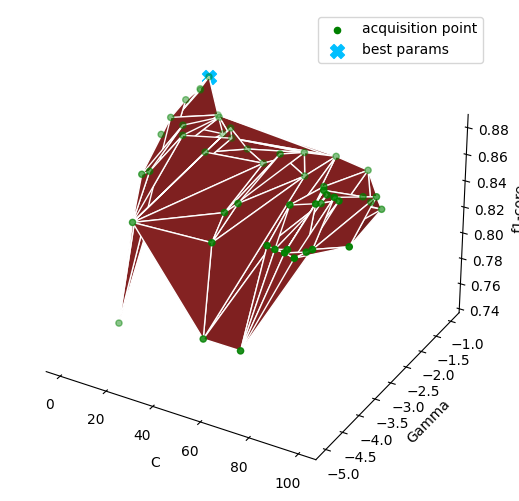

In [29]:
fig = plt.figure() 
ax3 = Axes3D(fig, auto_add_to_figure=False) 
fig.add_axes(ax3)
# 绘制3D散点
ax3.plot_trisurf(C, Gam, target,edgecolor='white',color='brown',label='Sampling')
sc=ax3.scatter(C, Gam, target, color='green',label='acquisition point')
sc2=ax3.scatter(p['params']['expC'],p['params']['expGamma'],p['target'],color='deepskyblue',marker='X',label='best params',s=100)
ax3.grid(None)
ax3.set_xlabel('C')
ax3.set_ylabel('Gamma')
ax3.set_zlabel('f1-core')
ax3.legend(handles=[sc,sc2])
ax3.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax3.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax3.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.tight_layout()
plt.show()

In [30]:
lisvm2 = svm.SVC(C=100,gamma=10**-3.5,kernel='rbf',verbose=1)
lisvm2.fit(x_train, y_train.ravel())
pred_y2_r=lisvm2.predict(x_test)
SVM_f1=f1_score(y_test,pred_y2_r,average='macro')
SVM_acc=accuracy_score(y_test, pred_y2_r)
SVM_recall=recall_score(y_test, pred_y2_r, average='macro')
print(metrics.classification_report(np.array(pred_y2_r.ravel()), np.array(y_test.ravel())))

[LibSVM]              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90        14
         1.0       0.93      0.88      0.90        16

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



In [31]:
lisvm = svm.SVC(C=param['expC'],cache_size=300, class_weight=None, coef0=0.0, degree=5, gamma=10**param['expGamma'], kernel='rbf',max_iter=-1, probability=True, random_state=1314, shrinking=True,tol=0.00001, verbose=1)
lisvm.fit(x_train, y_train.ravel())
pred_y2_s=lisvm.predict(x_test)
SVM_f1=f1_score(y_test,pred_y2_s,average='macro')
SVM_acc=accuracy_score(y_test, pred_y2_s)
SVM_recall=recall_score(y_test, pred_y2_s, average='macro')
print(metrics.classification_report(np.array(pred_y2_s.ravel()), np.array(y_test.ravel())))

[LibSVM]              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93        15
         1.0       0.93      0.93      0.93        15

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



#### KNN

In [32]:
from sklearn.neighbors import KNeighborsClassifier
knn_or = KNeighborsClassifier()
p = {
    'n_neighbors':list(range(1,20,1)),
    "weights": ['uniform', "distance"]
}
# model = LR(penalty='l2',max_iter=10000)
cv = KFold(n_splits=5,shuffle=True,random_state=12)
GS_KNN = GridSearchCV(knn_or,p,cv=cv)
GS_KNN.fit(x_train,y_train)
print(GS_KNN.best_params_)
knn=KNeighborsClassifier(n_neighbors=GS_KNN.best_params_['n_neighbors'], weights=GS_KNN.best_params_['weights'])
knn.fit(x_train, y_train)
pred_y_n= knn.predict(x_test)
KNN_f1=f1_score(y_test,pred_y_n,average='macro')
KNN_acc=accuracy_score(y_test, pred_y_n)
KNN_recall=recall_score(y_test, pred_y_n, average='macro')
print(metrics.classification_report(np.array(pred_y_n.ravel()), np.array(y_test.ravel())))

{'n_neighbors': 9, 'weights': 'distance'}
              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87        17
         1.0       0.80      0.92      0.86        13

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.88      0.87      0.87        30



## GaussianNB

In [33]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
pred_y_g = gnb.fit(x_train, y_train).predict(x_test)
g_f1=f1_score(y_test,pred_y_g,average='macro')
g_acc=accuracy_score(y_test, pred_y_g)
g_recall=recall_score(y_test, pred_y_g, average='macro')
print(metrics.classification_report(np.array(pred_y_g.ravel()), np.array(y_test.ravel())))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83        21
         1.0       0.60      1.00      0.75         9

    accuracy                           0.80        30
   macro avg       0.80      0.86      0.79        30
weighted avg       0.88      0.80      0.81        30



## 1d-CNN

In [34]:
model1d=Sequential()
model1d.add(Convolution1D(input_shape=(200,1),filters=16,kernel_size=5,padding='same',activation='relu'))
model1d.add(MaxPooling1D(pool_size=2,padding='same'))  
model1d.add(Convolution1D(filters=32,kernel_size=3,padding='same',activation='relu'))
model1d.add(MaxPooling1D(pool_size=2,padding='same'))  
model1d.add(Flatten())  
model1d.add(Dense(1,activation='sigmoid'))

model1d.summary()

model1d.compile(loss='binary_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])

hist2=model1d.fit(x_train, y_train, validation_split=.2, batch_size=20, epochs=20)

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 16)           96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_204 (Dense)           (None, 1)               

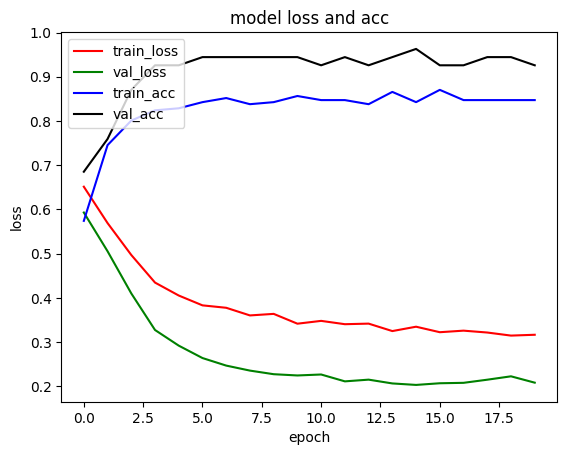

In [35]:
plt.plot(hist2.history['loss'],color='r')
plt.plot(hist2.history['val_loss'],color='g')
plt.plot(hist2.history['accuracy'],color='b')
plt.plot(hist2.history['val_accuracy'],color='k')
plt.title('model loss and acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss','train_acc', 'val_acc'], loc='upper left')
plt.show()

In [36]:
pred_y_1d=model2.predict(x_test)
pred_y_1d=(pred_y_1d > 0.5).astype("int32")
cnn_f1=f1_score(y_test,pred_y_1d,average='micro')
cnn_acc=accuracy_score(y_test, pred_y_1d)
cnn_recall=recall_score(y_test, pred_y_1d, average='macro')

In [37]:
print("1d_cnn")
print(metrics.classification_report(np.array(pred_y_d), np.array(y_test)))

1d_cnn
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.87      0.81      0.84        16

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.84      0.83      0.83        30



## experiment result

In [38]:
chart = pd.DataFrame({
    'Model': ['DNN','Logistic Regression','SVM','KNN','1d-cnn','GS'],
    'Accuracy':[DNN_acc,Rl_acc,SVM_acc,KNN_acc,cnn_acc,g_acc],
    'f1': [DNN_f1,Rl_f1,SVM_f1,KNN_acc,cnn_f1,g_f1],
    'Recall':[DNN_recall,Rl_recall,SVM_recall,KNN_acc,cnn_recall,g_recall],}
)
pd.set_option('display.colheader_justify', 'center')

print(chart)

         Model          Accuracy     f1      Recall 
0                  DNN  0.833333  0.833333  0.833333
1  Logistic Regression  0.833333  0.833148  0.833333
2                  SVM  0.933333  0.933333  0.933333
3                  KNN  0.866667  0.866667  0.866667
4               1d-cnn  0.833333  0.833333  0.833333
5                   GS  0.800000  0.791667  0.800000


0.9333333333333333


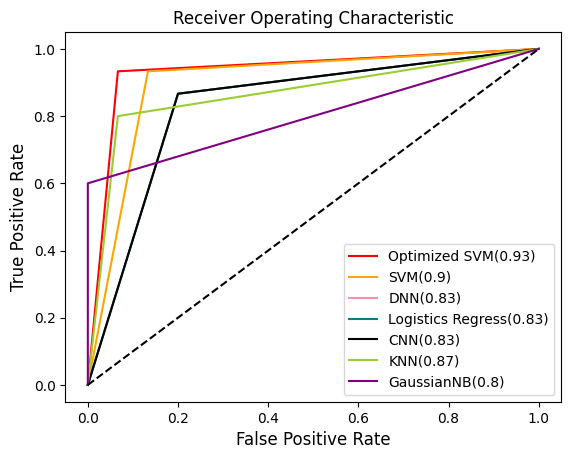

In [39]:
from sklearn.metrics import roc_curve, auc
fpr_s, tpr_s, _ = roc_curve(y_test.ravel(),pred_y2_s.ravel())
fpr_d, tpr_d, _ = roc_curve(y_test.ravel(),pred_y_d.ravel())
fpr_r, tpr_r, _ = roc_curve(y_test.ravel(),pred_y_r.ravel())
fpr_1d, tpr_1d, _ = roc_curve(y_test.ravel(),pred_y_1d.ravel())
fpr_n, tpr_n, _ = roc_curve(y_test.ravel(),pred_y_n.ravel())
fpr_g, tpr_g, _ = roc_curve(y_test.ravel(),pred_y_g.ravel())
fpr_rsvm, tpr_rsvm, _ = roc_curve(y_test.ravel(),pred_y2_r.ravel())
plt.figure()
plt.plot(fpr_s,tpr_s,'r',label='Optimized SVM('+str(np.round(auc(fpr_s,tpr_s),2))+')')
plt.plot(fpr_rsvm,tpr_rsvm,'orange',label='SVM('+str(np.round(auc(fpr_rsvm,tpr_rsvm),2))+')')
plt.plot(fpr_d,tpr_d,'#f391a9',label='DNN('+str(np.round(auc(fpr_d,tpr_d),2))+')')
plt.plot(fpr_r,tpr_r,'teal',label='Logistics Regress('+str(np.round(auc(fpr_r,tpr_r),2))+')')
plt.plot(fpr_1d,tpr_1d,'black',label='CNN('+str(np.round(auc(fpr_1d,tpr_1d),2))+')')
plt.plot(fpr_n, tpr_n,'yellowgreen',label='KNN('+str(np.round(auc(fpr_n,tpr_n),2))+')')
plt.plot(fpr_g, tpr_g,'purple',label='GaussianNB('+str(np.round(auc(fpr_g,tpr_g),2))+')')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate',fontsize=12)
plt.ylabel('True Positive Rate',fontsize=12)
plt.title('Receiver Operating Characteristic')
plt.legend()
f=plt.gcf()
f.savefig('roc7311',dpi=200)
print(auc(fpr_s,tpr_s))